In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import utils
from utils import *
import os
import importlib
import argparse
import trader   # 파일 수정 반영
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
binance = get_binance()

binance requires to release all resources with an explicit call to the .close() coroutine. If you are using the exchange instance with async coroutines, add `await exchange.close()` to your code into a place when you're done with the exchange and don't need the exchange instance anymore (at the end of your async coroutine).
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7b7bbf73ad00>


In [28]:
tf = "1m"
limit = 1500
past_df_dic = {}
new_symlist = []
for sym in SYMLIST[0:50]:
    vol = await binance.fetch_tickers(symbols=[sym])
    if (not len(list(vol.values())) > 0) or list(vol.values())[0]['quoteVolume'] < 20*(10**6):
        continue
    df = await past_data(binance, sym, tf, limit)
    df["mean"] = np.mean([df["open"], df["high"], df["low"], df["close"]], axis=0)
    past_df_dic.update({sym: df})
    new_symlist.append(sym)

In [41]:
def bull_or_bear(df,ref=0.01):
    m = (df['high']+df['low'])/2  # df['close']로 해도 되는데 그냥 이렇게 함
    rising = []
    for i in range(1, len(m)-1):
        rising.append((m[i+1] - m[i])/m[i]*100)
    rising_coef = np.mean(rising)
    
    if rising_coef > ref:
        return "BULL", rising_coef
    elif rising_coef < -ref:
        return "BEAR", rising_coef
    else:
        return "ZZ", rising_coef
    
def inspect_market(df, block):
    st1, score1 = bull_or_bear(df[int(block/4):])
    st2, score2 = bull_or_bear(df)
    score = score1+score2
    
    if st2 == 'BULL' and st1 == "BULL":
        return LONG, score
    elif st2 == 'BEAR' and st1 == "BEAR":         # 4시간동안 상승
        return SHORT, score
    return None, 0

In [57]:
def select_sym(t, block):
    max_score, min_score = 0,0
    max_sym, min_sym = 0,0
    for sym in new_symlist:
        df = past_df_dic[sym][t-block:t]
        position, score = inspect_market(df, block)
        
        if score > max_score:
            max_score, max_sym = score, sym
        elif score < min_score:
            min_score, min_sym = score, sym

    if (abs(max_score) > 0 or abs(min_score) > 0 ) and position:
        print(f"== MAX: {max_sym} {max_score} | MIN: {min_sym} {min_score} ==")
        if abs(max_score) > abs(min_score):
            return max_sym, position
        else:
            return min_sym, position 
    return None, None

In [60]:

def get_pnl(open_price, price):
    return (price - open_price)/open_price

def run(t, sl, tp, lev, block):
    sym, position = select_sym(t, block)
    if not sym and not position:
        return 0,0,0,0,0,0
    sym_df = past_df_dic[sym]['mean'][t:]

    open_price = sym_df[0]
    
    for i, mean_price in enumerate(sym_df[1:]):
        coef = 1 if position == "Long" else -1
        pnl = get_pnl(open_price, mean_price) * lev * coef * 100 - 0.7
        if pnl > tp or pnl < sl:
            # print(open_price, mean_price, pnl, position)
            return i+1, open_price, mean_price, pnl, sym, position
        
    return 0,0,0,0,0,0
        
def show_default_graph(df, t, time_i, open_price, close_price, position, title=""):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize = (12,6))

    x = len(df)
    
    ax.plot(range(x), df, color = (1, 0.7, 0), linewidth = 2, label='mean price')
        
    color = 'b' if position == 'Short' else 'r'
    ax.add_patch(plt.Arrow(
        t, open_price, time_i, close_price-open_price,
        width = (close_price-open_price)*2, color=color, zorder=2, alpha=0.5
    ))
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')

    ax.set_title(title)
    os.makedirs("backtest_result", exist_ok=True)
    plt.savefig(f"backtest_result/{t}.jpg")
    return ax

def simul(pnls):
    orig = 100
    profit = 0
    for pnl in pnls:
        if pnl != 0:
            profit += orig*(pnl*0.01)
    return orig+profit

== MAX: TIA/USDT 0.06912490461366005 | MIN: XAI/USDT -0.031997374164299194 ==
== MAX: DYM/USDT 0.13103769379338487 | MIN: 0 0 ==
== MAX: DYM/USDT 0.15325292292959303 | MIN: 0 0 ==
== MAX: DYM/USDT 0.09164906398578257 | MIN: 0 0 ==
== MAX: ORDI/USDT 0.03240284316641889 | MIN: RUNE/USDT -0.032132369111256026 ==
== MAX: ORDI/USDT 0.05168930955446462 | MIN: DYM/USDT -0.04925116707293001 ==
== MAX: TRB/USDT 0.11983994695050804 | MIN: 0 0 ==
== MAX: AXL/USDT 0.10325955342740764 | MIN: 0 0 ==
== MAX: TRB/USDT 0.04483844347501531 | MIN: 0 0 ==
== MAX: TRB/USDT 0.05163695078296359 | MIN: AXL/USDT -0.045646744114048884 ==
== MAX: 0 0 | MIN: XAI/USDT -0.035368504971472245 ==
== MAX: 0 0 | MIN: XAI/USDT -0.0309811313741884 ==
== MAX: 0 0 | MIN: XAI/USDT -0.030063399367812858 ==
== MAX: 0 0 | MIN: XAI/USDT -0.05198786976590012 ==
== MAX: 0 0 | MIN: XAI/USDT -0.05569604844494236 ==
== MAX: XAI/USDT 0.06556441468558044 | MIN: 0 0 ==
== MAX: XAI/USDT 0.06027742568286676 | MIN: 0 0 ==
== MAX: XAI/USDT 

/tmp/ipykernel_3271824/1610501077.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize = (12,6))


== MAX: XAI/USDT 0.04019077368143503 | MIN: PEOPLE/USDT -0.05840245185015469 ==
== MAX: TIA/USDT 0.07274928916297647 | MIN: XAI/USDT -0.06620438989930952 ==
== MAX: TIA/USDT 0.02782108907747369 | MIN: XAI/USDT -0.0868648830881491 ==
== MAX: 0 0 | MIN: XAI/USDT -0.11110058996632245 ==
== MAX: 0 0 | MIN: TIA/USDT -0.1056163092406655 ==
== MAX: 0 0 | MIN: TIA/USDT -0.07602943410043256 ==
== MAX: 0 0 | MIN: TIA/USDT -0.09322038147939425 ==
== MAX: 0 0 | MIN: TIA/USDT -0.1120280046167389 ==
== MAX: 0 0 | MIN: TIA/USDT -0.08174628788906203 ==
== MAX: 0 0 | MIN: TIA/USDT -0.06227224591186847 ==
== MAX: TRB/USDT 0.03075472776870869 | MIN: ORDI/USDT -0.03982933974595658 ==
== MAX: MANTA/USDT 0.058755702800539086 | MIN: 0 0 ==
== MAX: TRB/USDT 0.049006003870004755 | MIN: 0 0 ==
== MAX: JUP/USDT 0.05274593168373485 | MIN: 0 0 ==
== MAX: JUP/USDT 0.04797869820459341 | MIN: 0 0 ==
0.6222264197360534


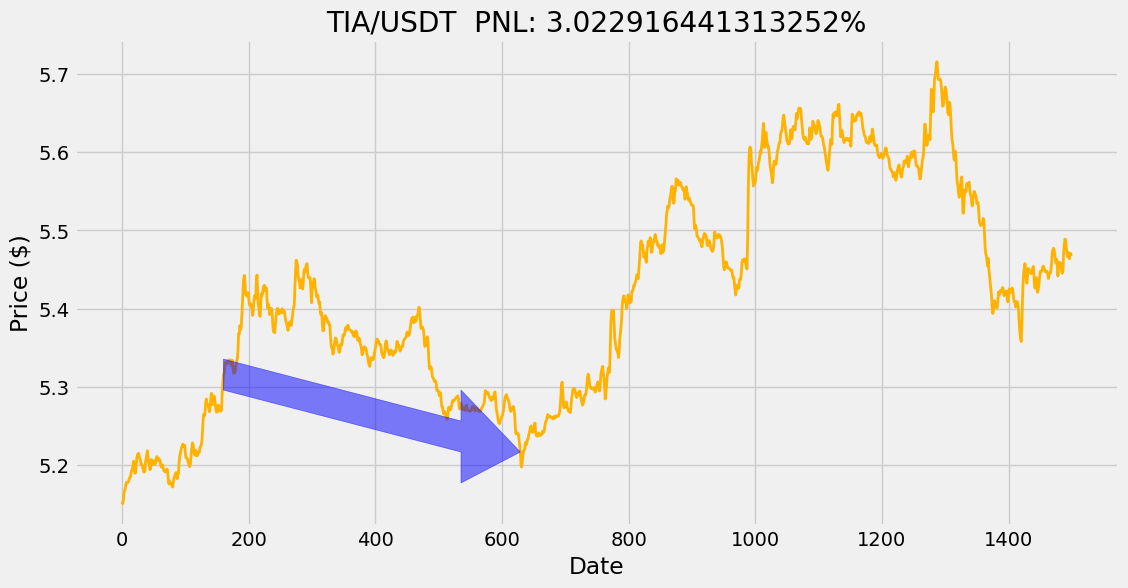

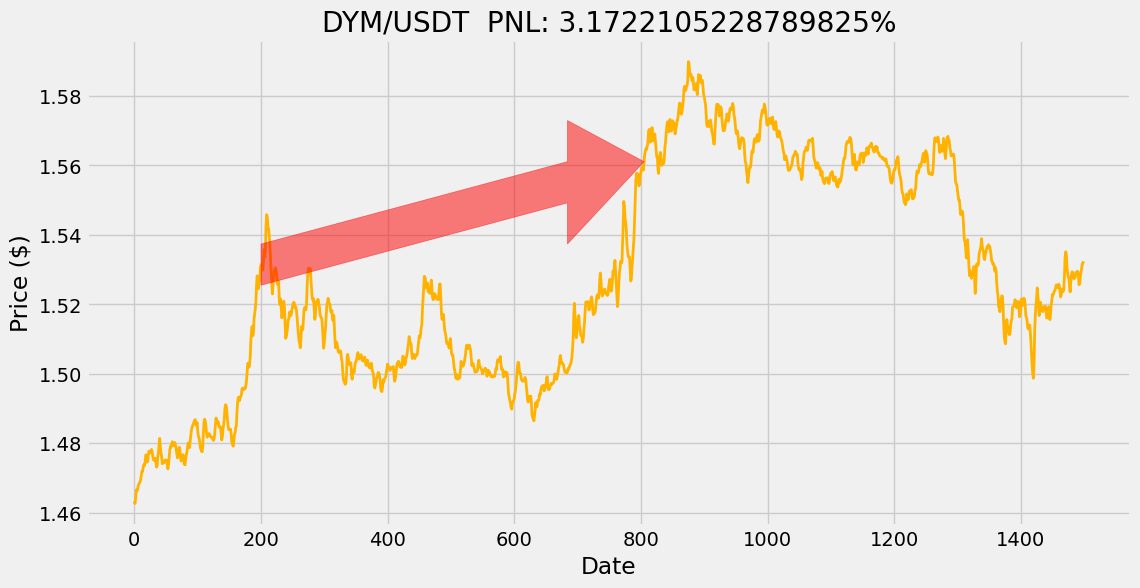

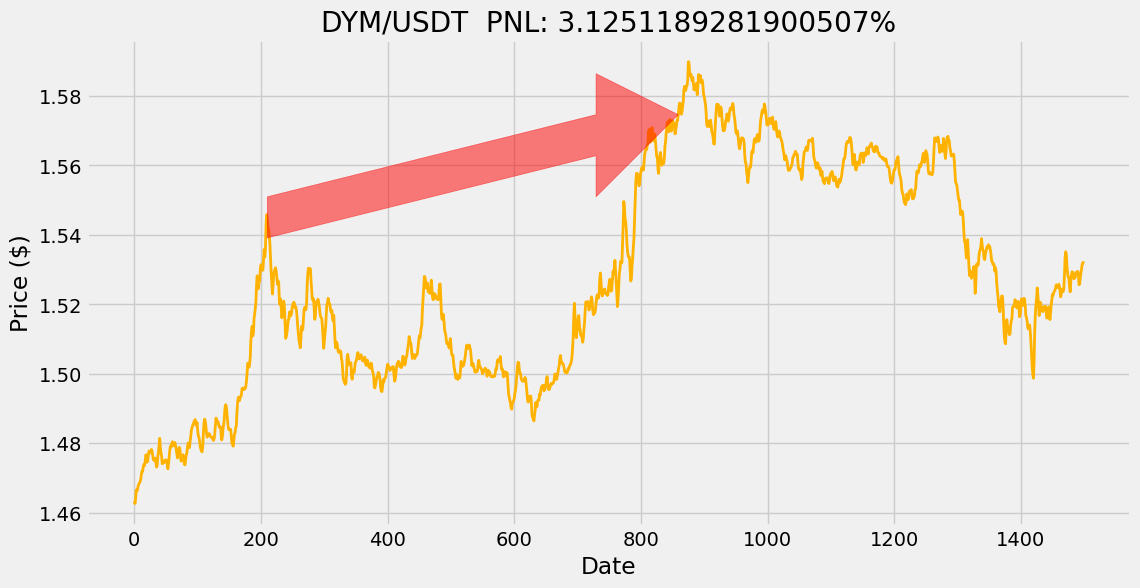

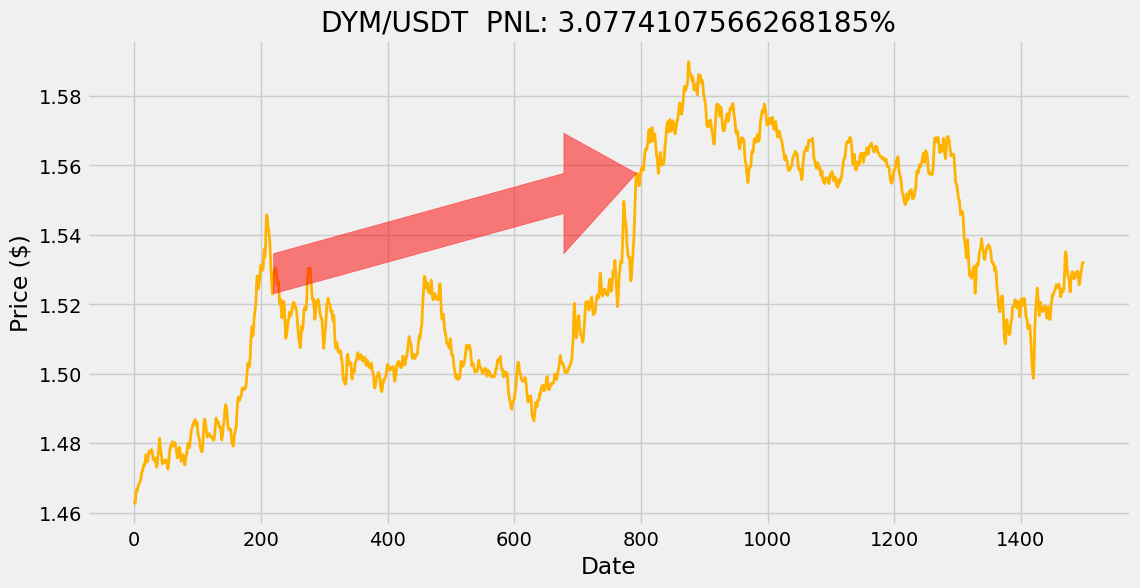

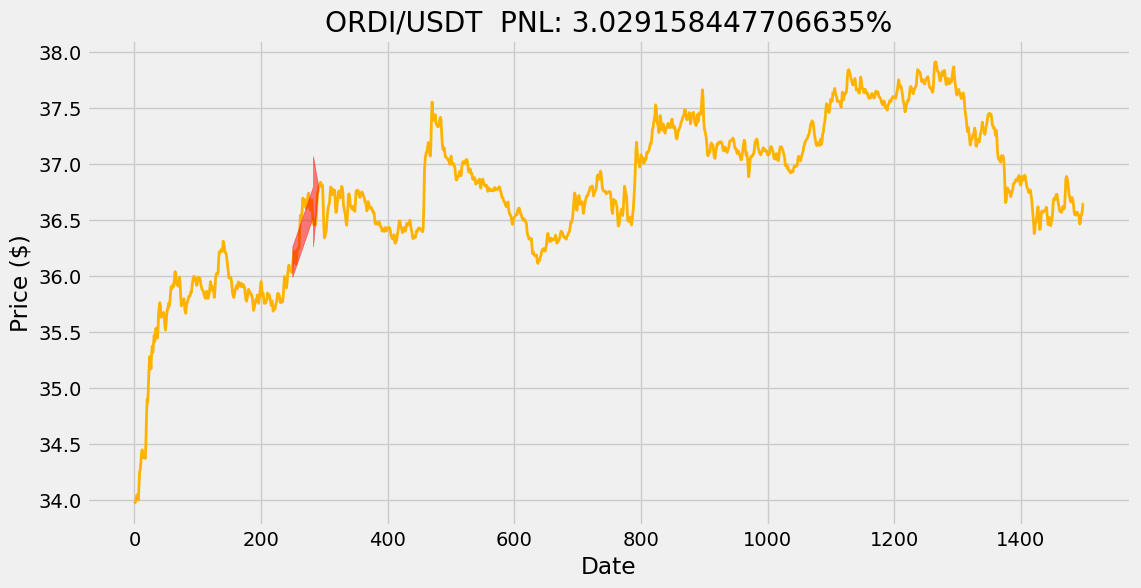

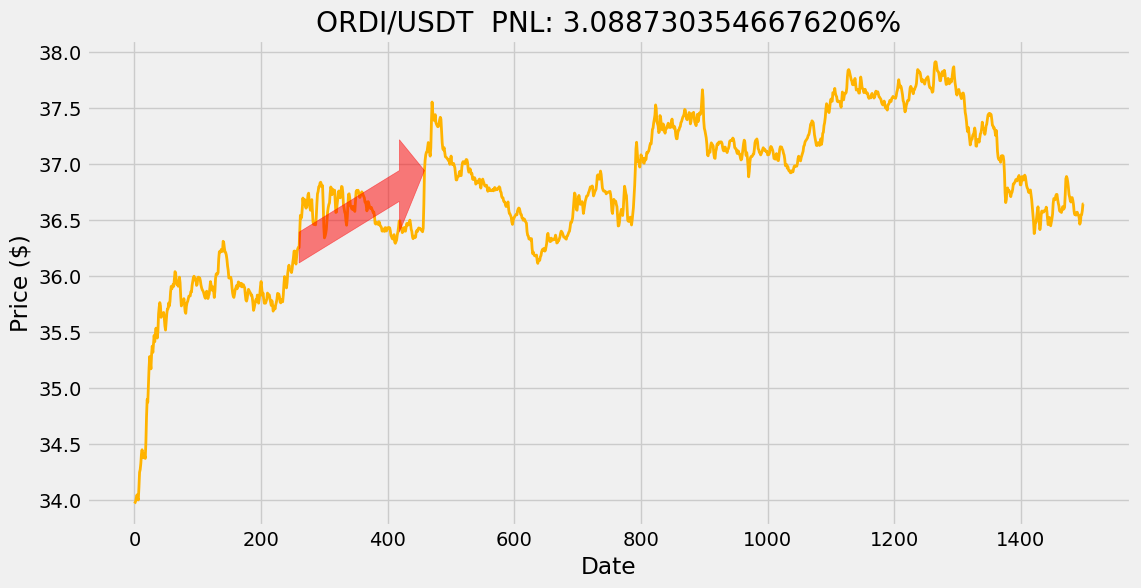

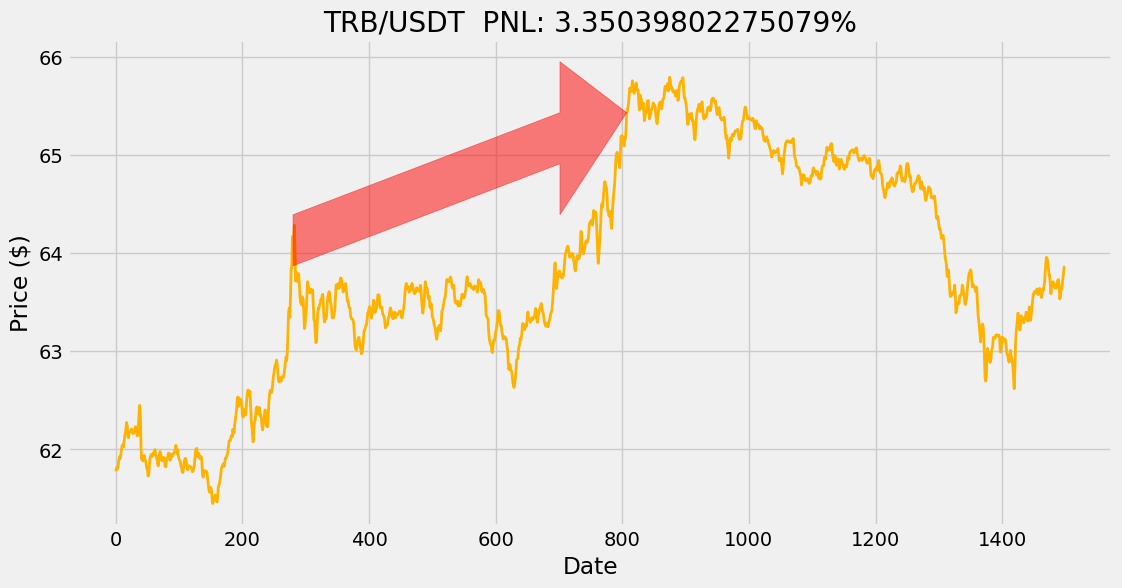

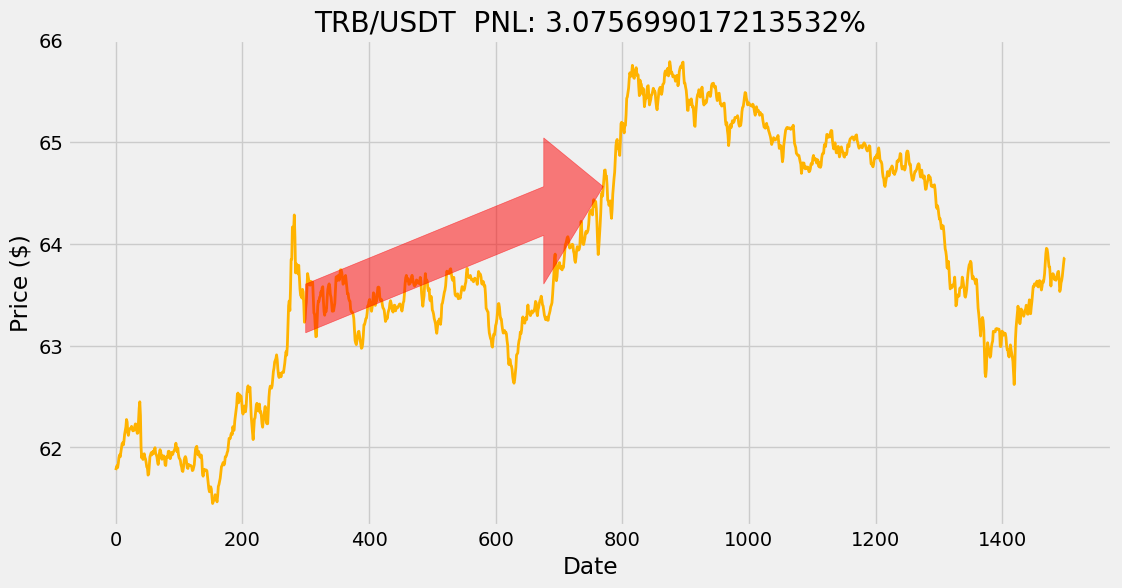

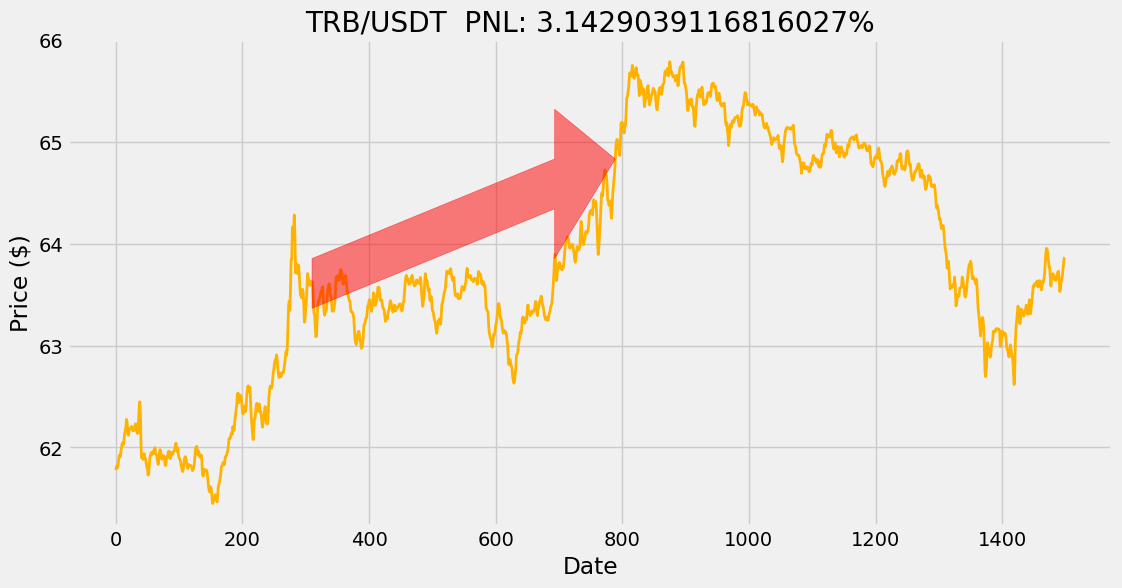

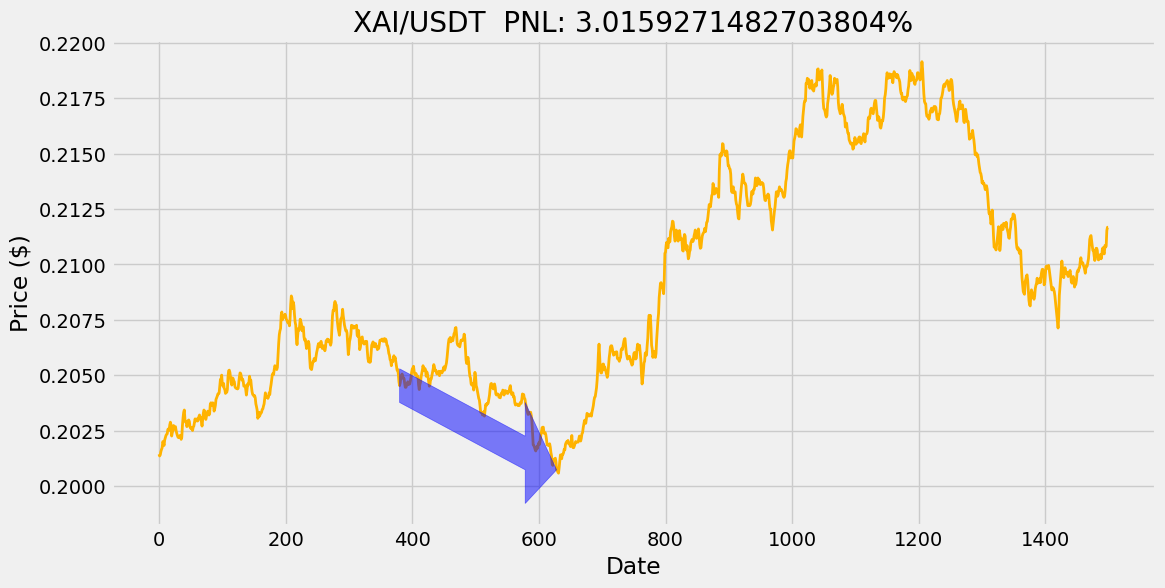

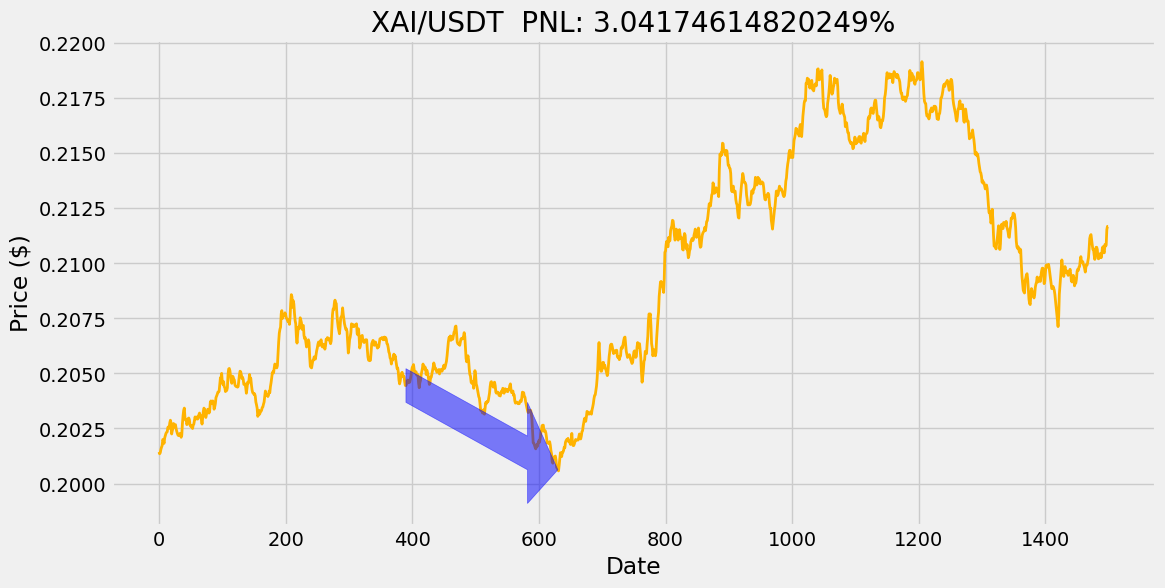

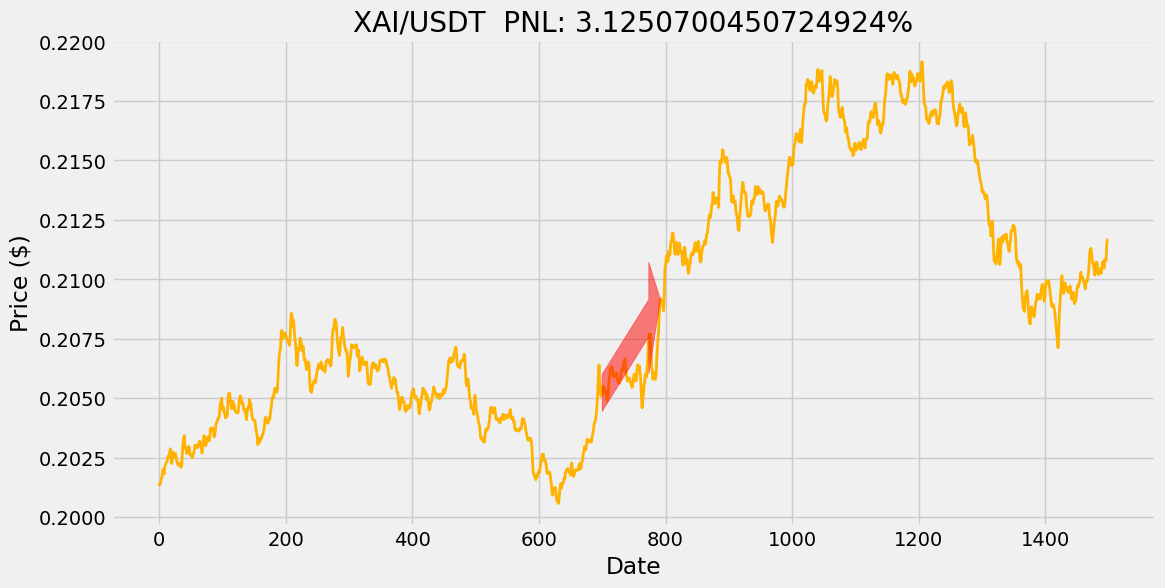

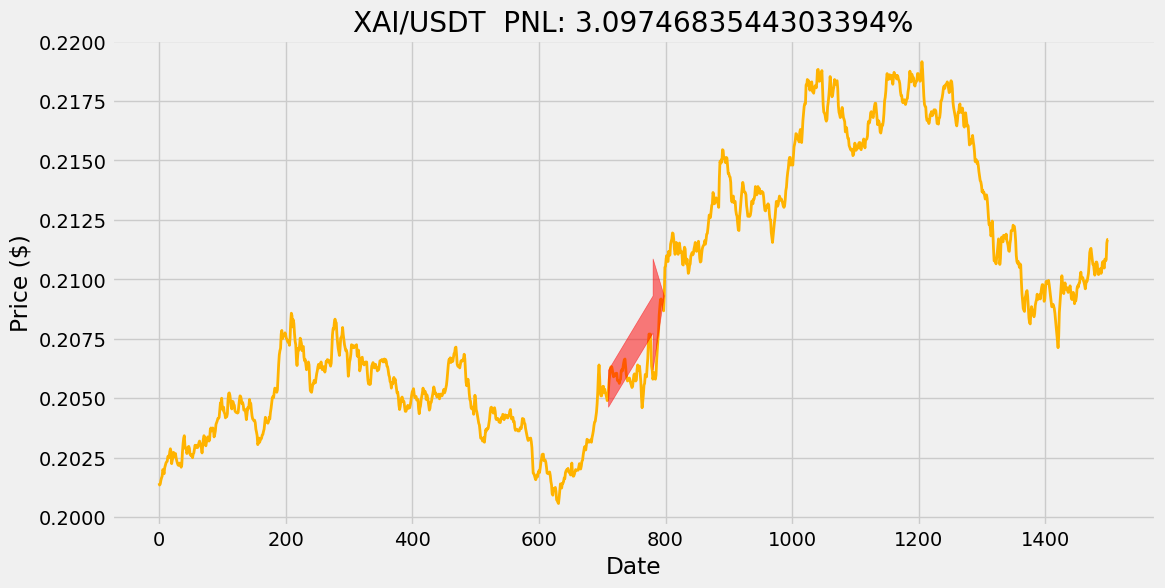

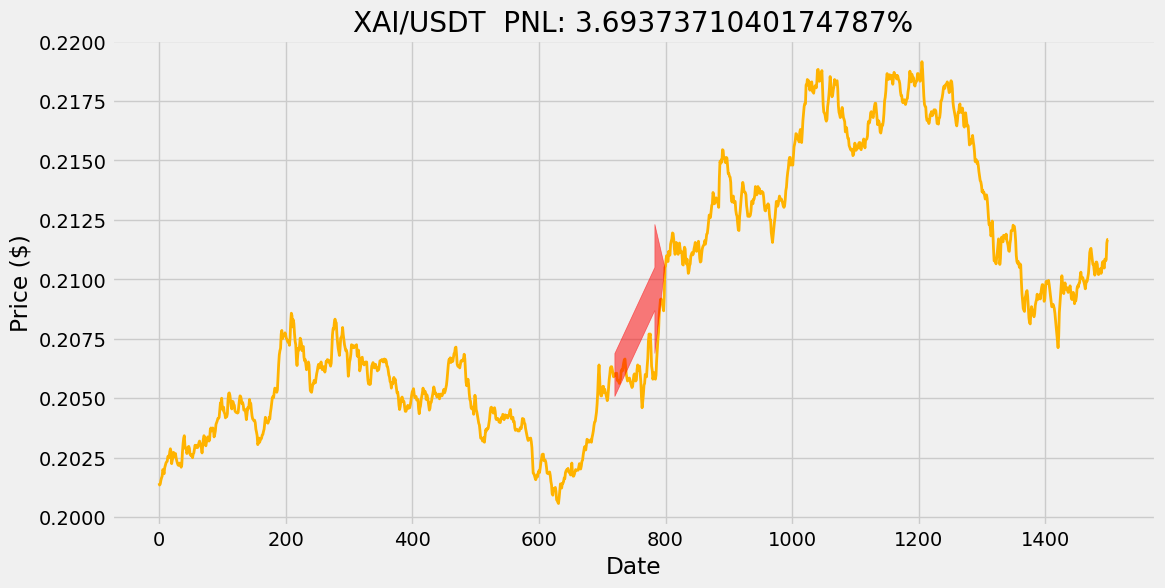

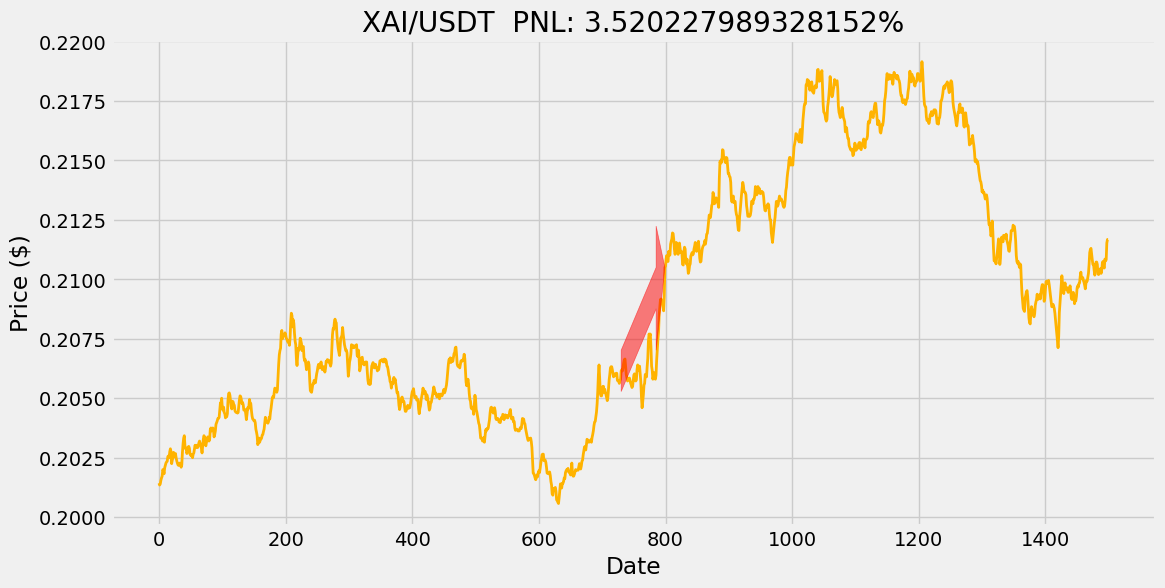

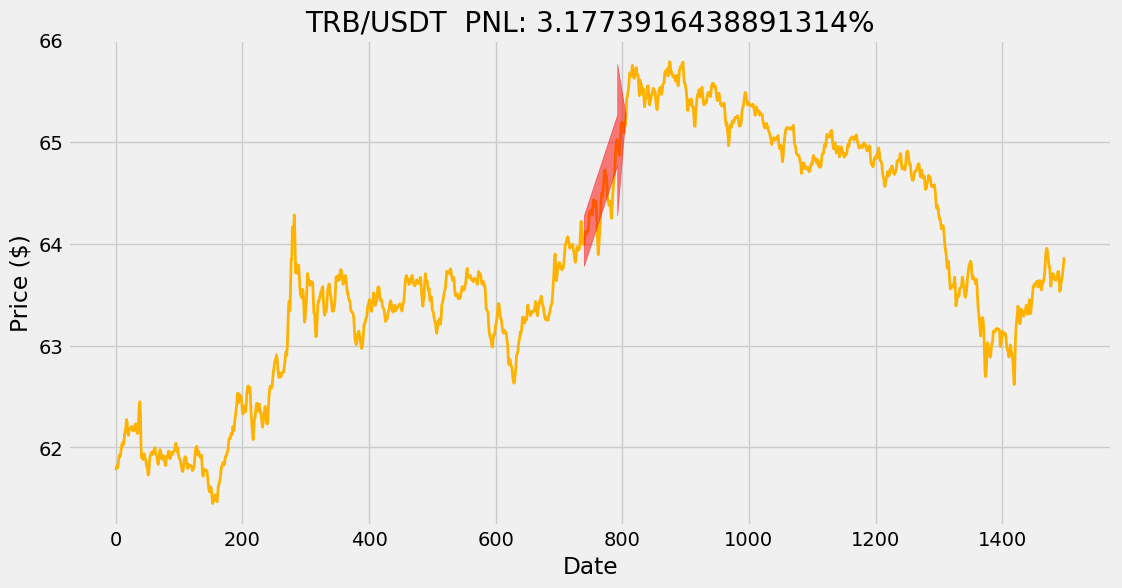

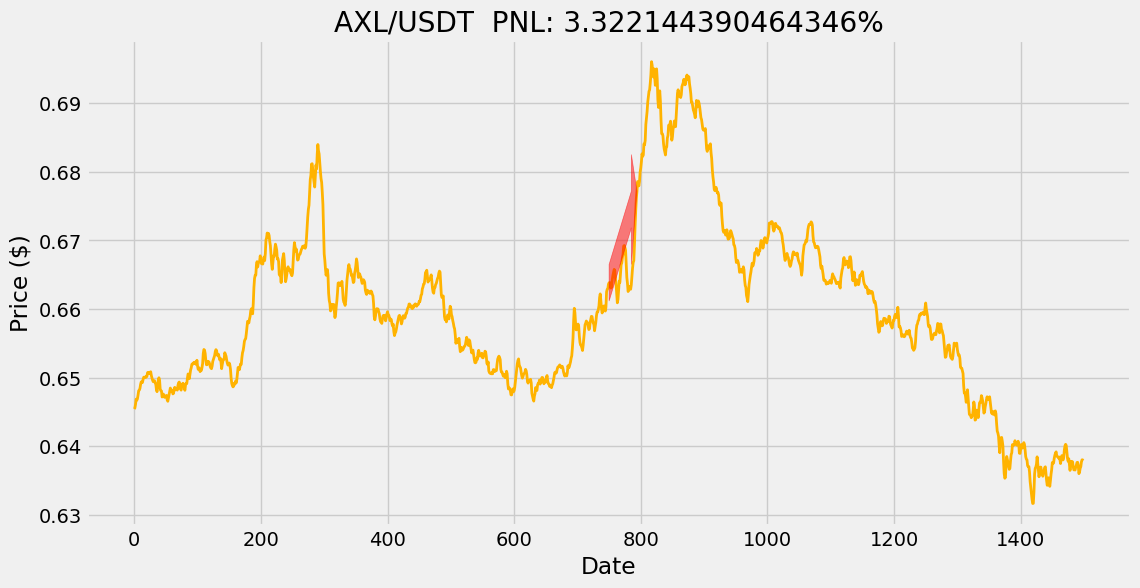

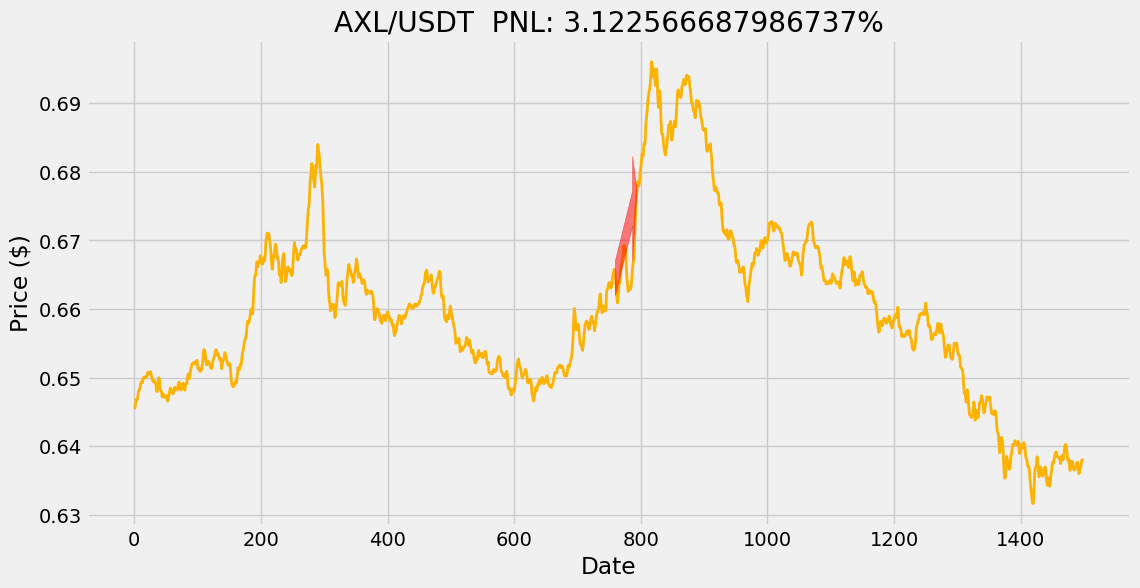

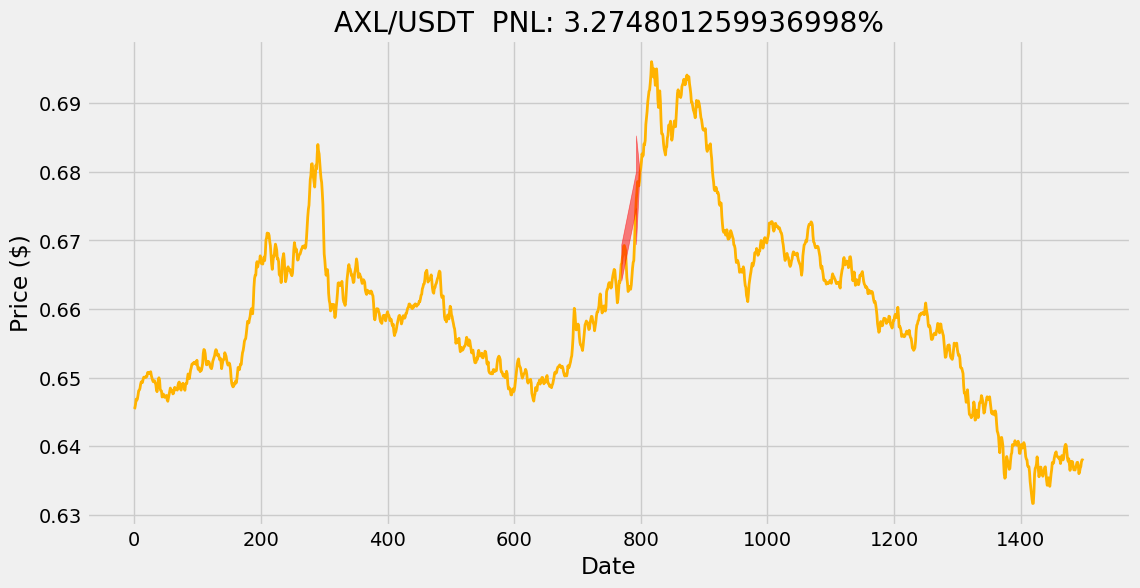

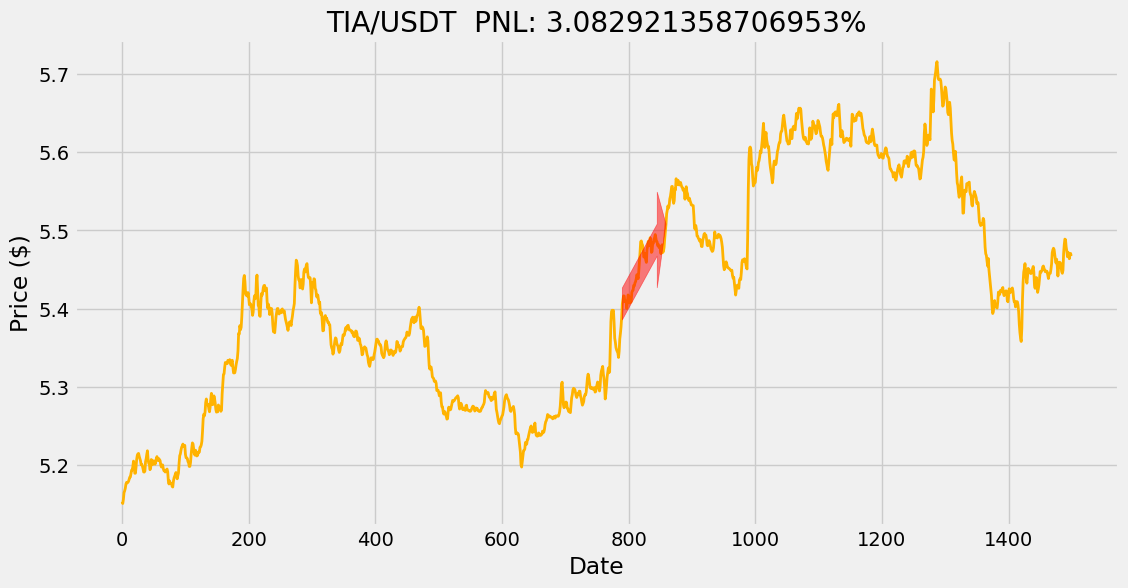

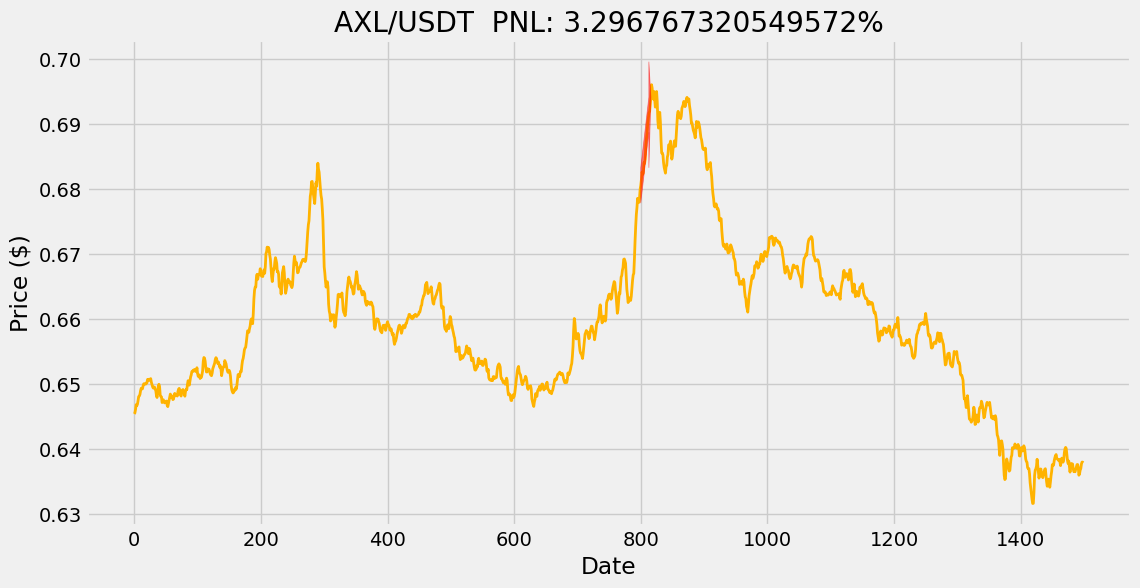

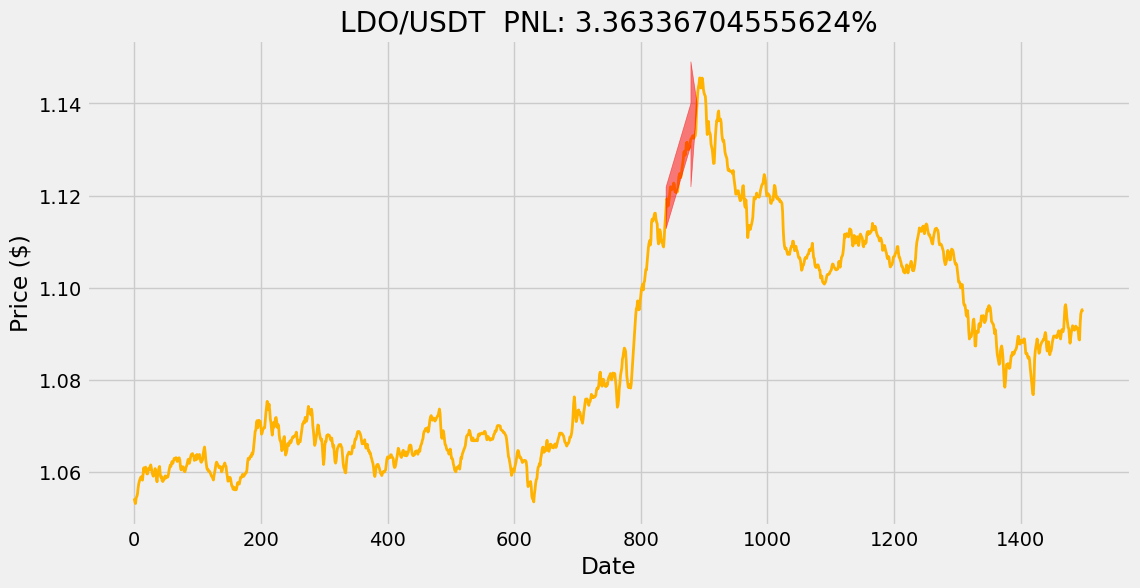

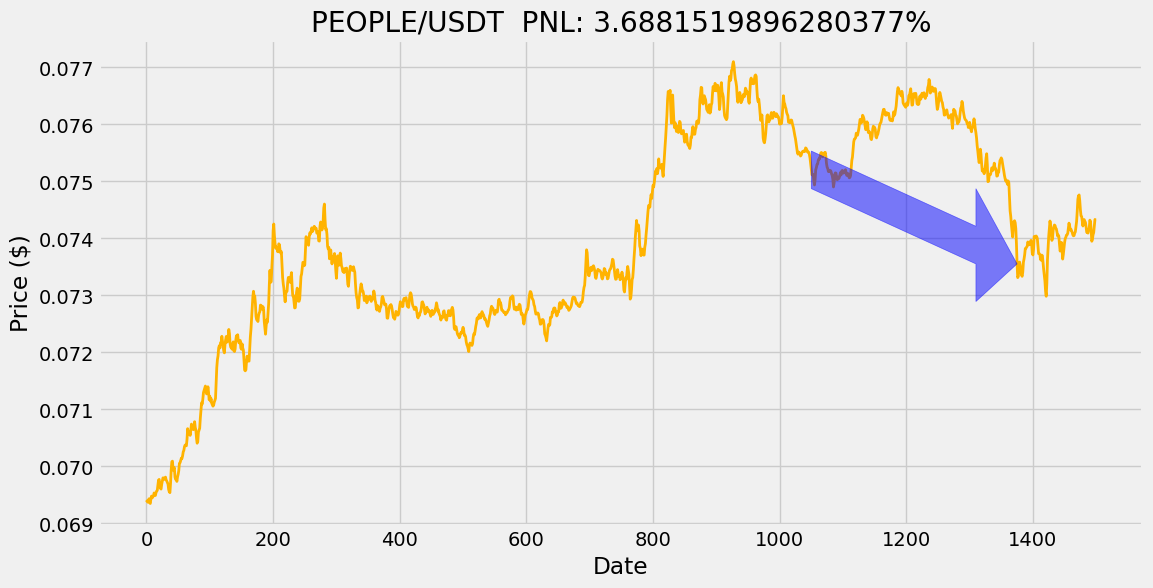

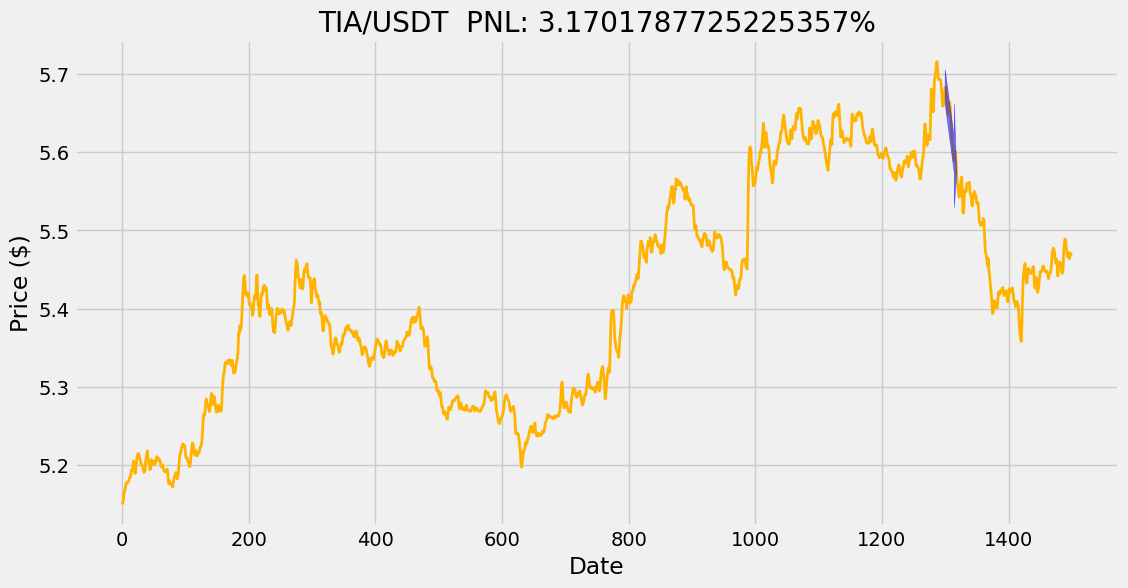

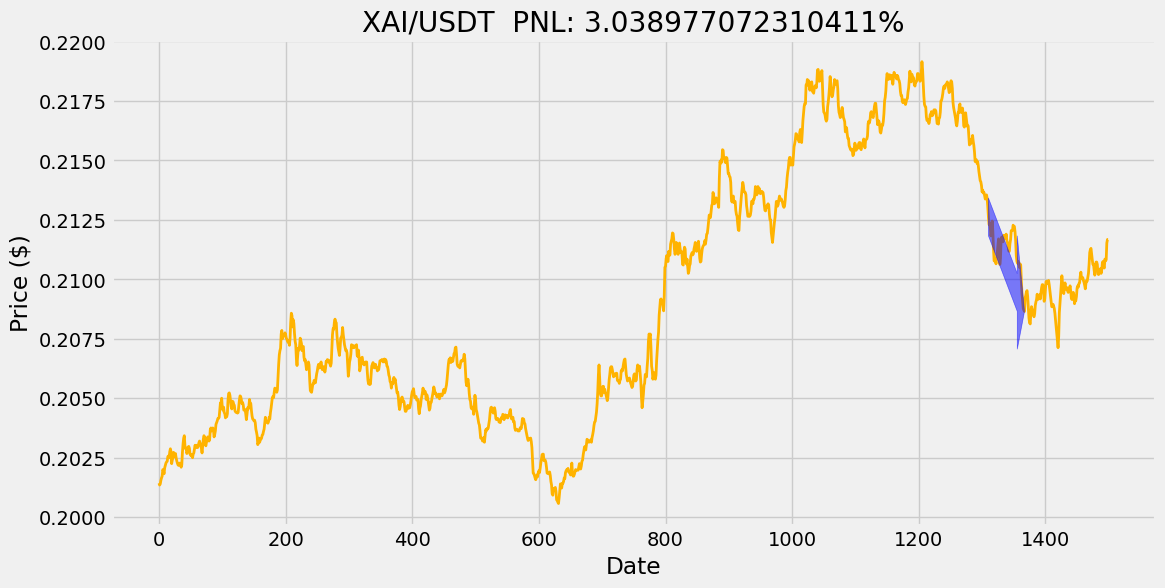

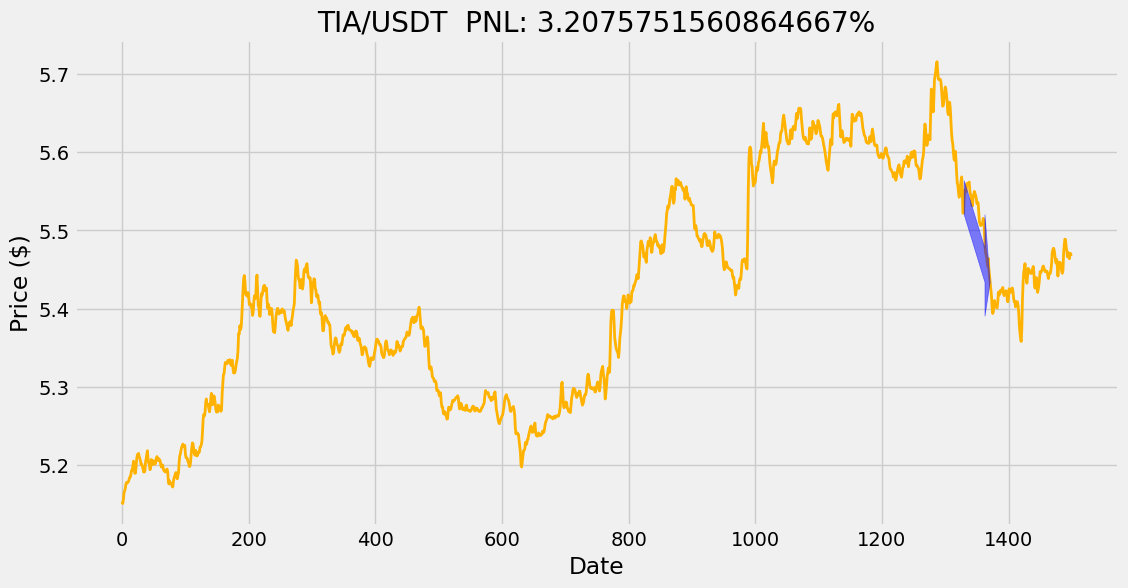

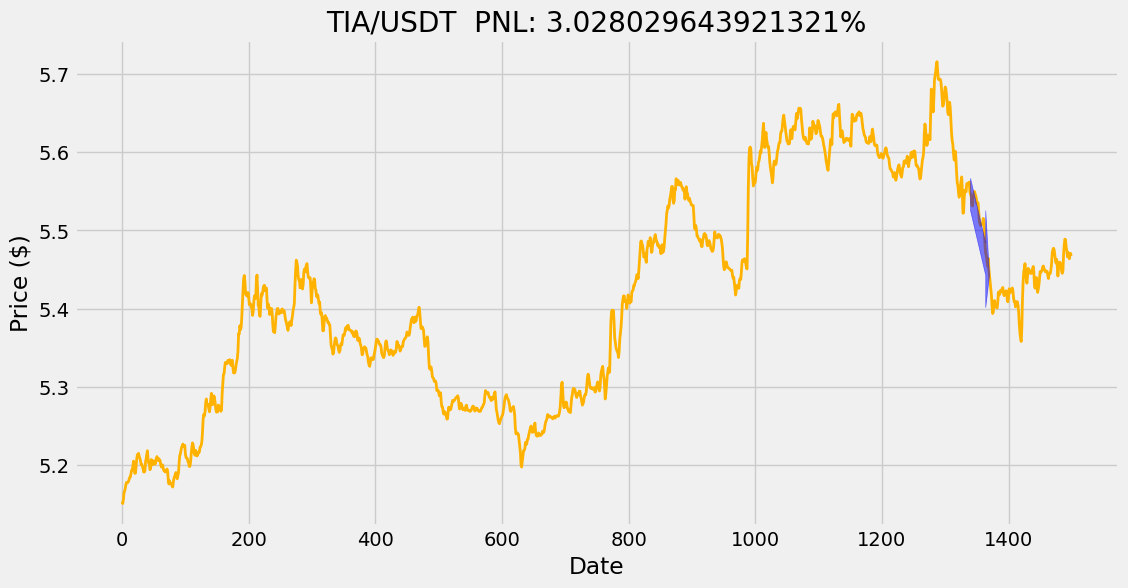

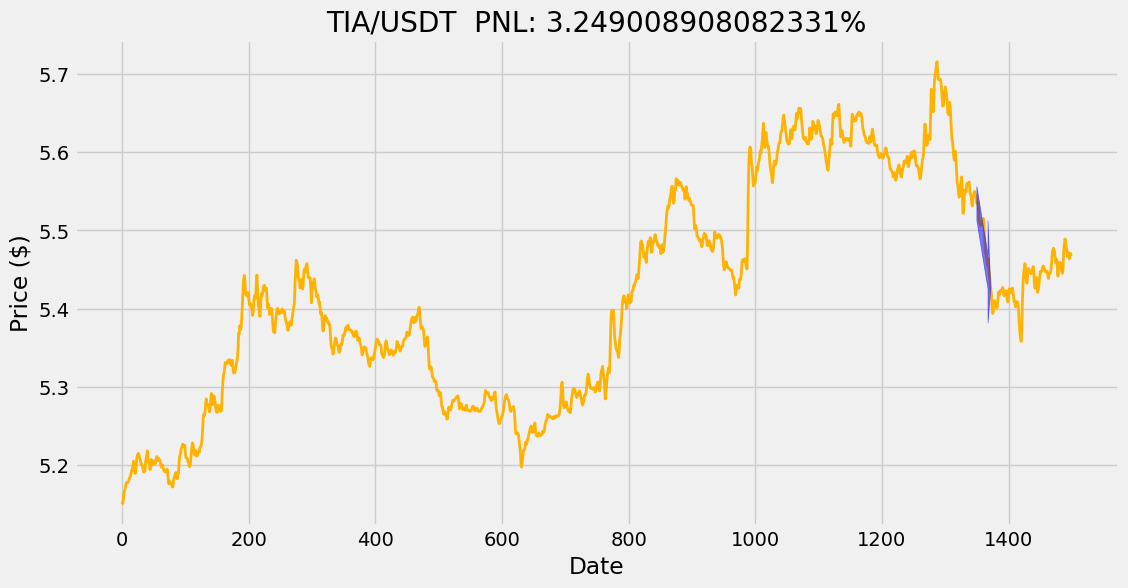

In [64]:
sl, tp = -30, 3
lev = 2
pnls = []
block = 60

for t in range(block, 1500, 10):
    time_i, open_price, close_price, pnl, sym, position = run(t, sl, tp, lev, block)
    pnls.append(pnl)
    if pnl != 0:
        show_default_graph(past_df_dic[sym]['mean'], t, time_i, open_price, close_price, position, title=f"{sym}  PNL: {pnl}%")
        
print(np.mean(pnls))

In [65]:
pnls = np.array(pnls)
print(f"Total PNL: {np.sum(pnls)}%,    # of good pred: {np.sum(np.where(pnls>0, 1, 0))},    bad pred: {np.sum(np.where(pnls<0, 1, 0))}")
simul(pnls)

Total PNL: 89.60060444199169%,    # of good pred: 28,    bad pred: 0


189.60060444199172